# 02467 Assignment 2
s204085 Cornelius Erichs & s204076 Natasha Hougaard & s194101 Otto Schmidt

#### GitHub repository
Here is our repository on GitHub: https://github.com/natasha0301/Assigment2-CSS


## Part 1: Mixing Patterns and Assortativity

**EXERCISE 1: MIXING PATTERNS AND ASSTORTATIVITY**

For each node, compute the fraction of edges that connect to a node that works in the same top field. Find the average value across all nodes.

In [ ]:
from networkx.readwrite import json_graph
import networkx as nx
import json
import numpy as np
import pandas as pd

def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)
G = read_json_file("data_total.json")

def same_field(G):
    same_field_fractions = []
    for node in G.nodes():
        same_field_neighbors = 0
        total_neighbors = 0
        
        for neighbor in G.neighbors(node):
            if G.nodes[neighbor]["field"] == G.nodes[node]["field"]:
                same_field_neighbors += 1
            total_neighbors += 1
        
        if total_neighbors > 0:
            same_field_fraction = same_field_neighbors / total_neighbors
        else:
            same_field_fraction = 0
        same_field_fractions.append(same_field_fraction)
    return same_field_fractions

same_field_fractions = same_field(G)
print(np.mean(same_field(G)))

Create a new graph, with the same nodes and edges, but where the association between nodes and field is shuffled. Compute the measure above for this randomized graph.

In [ ]:
import random

shuffled_G = G.copy()

fields = [G.nodes[node]["field"] for node in G.nodes()]
random.shuffle(fields)

for i, node in enumerate(shuffled_G.nodes()):
    shuffled_G.nodes[node]["field"] = fields[i]
    
print(np.mean(same_field(shuffled_G)))

Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Is the chance to connect to a member of the same field significantly higher than it would be by chance?

In [ ]:
import matplotlib.pyplot as plt
results = []
for i in range(500):
    random.shuffle(fields)

    for i, node in enumerate(shuffled_G.nodes()):
        shuffled_G.nodes[node]["field"] = fields[i]
    
    results.append(np.mean(same_field(shuffled_G)))
    
plt.hist(results)

Compute the assortativity coefficient with respect to author's field. How do you interpret the value you obtain? 

In [ ]:
print(np.unique(fields))
unique_fields = {'Agricultural And Food Sciences' : 0,
            'Art' : 1,
            'Business' : 2,
            'Chemistry' : 3,
            'Computer Science' : 4,
            'Economics' : 5,
            'Education' : 6,
            'Engineering' : 7,
            'Environmental Science' : 8,
            'Geography' : 9,
            'Geology' : 10,
            'History' : 11,
            'Law' : 12,
            'Linguistics': 13,
            'Materials Science': 14,
            'Mathematics': 15,
            'Medicine': 16,
            'Philosophy' : 17,
            'Physics' : 18,
            'Political Science' : 19,
            'Psychology' : 20,
            'Sociology' : 21,
            None:22}

matrix = np.zeros((len(unique_fields),len(unique_fields)))

values = nx.get_node_attributes(G, "field").values()
num_values = len(values)

for start, end in G.edges(): # Looping over all edges in graph (since its undirected its not really start and stop)
    x = G.nodes[start]["field"] # Getting the start point of the edge 
    y = G.nodes[end]["field"] # Getting the end point of the edge 
    if x in unique_fields: 
        x = unique_fields[x]
    else:
        x = unique_fields[None] # in case x is nan
        
    if y in unique_fields:
        y = unique_fields[y]
    else:
        y = unique_fields[None] # in case y is nan
    matrix[x, y] += 1 
    
num_edges = len(G.edges())
matrix /= num_edges # averaging the occurence with the total edges

trace = np.trace(matrix) # trace of the matrix, the sum of the diagonal entries
mix_matrix = np.sum(np.matmul(matrix, matrix))

r1 = (trace-mix_matrix)/(1-mix_matrix) # Eq. 2
print(r1)

The result of 0.71 indicated some clusters of nodes are formed based on their top field, but there are also occurences where this is not the case. With 0 indicating random mixing we can see that their field plays some kind of role.

Is the graph assortative with respect to the degree? (e.g. do high-degree scientists tend to link to other high-degree scientists, and low-degree scientists to other low-degree scientists?). Provide an interpretation of your answer.

If the assortativity coefficient is > 0, it suggests that nodes with similar degrees tend to be connected to each other, indicating assortative mixing w.r.t. the degree. And if the assortativity coefficient is < 0, it suggests that nodes with different degrees tend to be connected to each other, indicating disassortative mixing w.r.t. the degree. 

A value of 0.71 for the assortativity coefficient suggests that there is a degree of assortative mixing for the authors with respect to the their top fields. In other words, authors with the same top field are more likely to be connected to each other than to nodes with different top fields.

## Part 2: Communities

**EXERCISE 2: ZACHARYS'S KARATE CLUB**

In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function karate_club_graph

1. Visualize the graph using netwulf. Set the color of each node based on the club split

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from netwulf import visualize

G_karate = nx.karate_club_graph()

#First we set the color of each node based on the club split
colors = ['red' if G_karate.nodes[n]['club'] == 'Mr. Hi' else 'blue' for n in G_karate.nodes()]

#Then we add the colors to the node attributes
for i, n in enumerate(G_karate.nodes()):
    G_karate.nodes[n]['color'] = colors[i]

#Visualize the graph
network, config = visualize(G_karate)

2. Write a function to compute the modularity of a graph partitioning using equation 9.12 in the book: 

$M=\sum_{c=1}^{n_c}\left[\frac{L_c}{L}-(\frac{k_c}{2L})^2\right]$ 



The function should take a networkX Graph and a partitioning as inputs and return the modularity.

In [ ]:
"""
def compute_modularity(G,partitioning):
    L = G.number_of_edges()
    M = 0
    communities = set(partitioning.values())

    for community in communities:
        nodes_in_community = [node for node, community_id in partitioning.items() if community_id == community]
        subgraph = G.subgraph(nodes_in_community)
        k_c = sum(dict(subgraph.degree()).values())
        L_c = subgraph.number_of_edges()
        M += L_c / L - (k_c / (2 * L)) ** 2

    return M
"""

3. Explain in your own words the concept of modularity

Modularity measures the structure of a network, which contains nodes and the edges(links) that connect them. Modularity is based on the idea that a well-connected network can be divided into groups of nodes, known as communities or clusters, where the nodes within each group are more tightly connected to each other than to nodes outside the group. Modularity is a measure of how well a network can be divided into such communities. So, it is the difference between the number of edges within communities and the expected number of edges within communities if the edges were placed randomly, while preserving the degree distribution of the nodes. Modularity is typically expressed as a number between -1 and 1. A high positive value tells us that the network is very modular and has many densely connected communities, while a low or negative value indicates that the network is less modular, with communities that are not well-defined. 

4. Compute the modularity of the Karate club split partitioning using the function you just wrote

In [2]:
import networkx as nx

def compute_modularity(Graph,partitioning):
    L = Graph.number_of_edges()
    M = 0
    communities = set(partitioning.values())

    for community in communities:
        nodes_in_community = [node for node, community_id in partitioning.items() if community_id == community]
        subgraph = Graph.subgraph(nodes_in_community)
        k_c = sum(dict(subgraph.degree()).values())
        L_c = subgraph.number_of_edges()
        M += L_c / L - (k_c / (2 * L)) ** 2

    return M

#We start by loading the Karate club graph
G_karate = nx.karate_club_graph()

#First we get the club split partitioning from the node attributes
club_split = nx.get_node_attributes(G_karate, "club")

#Then we compute the modularity of the partitioning by using the function above
modularity = compute_modularity(G_karate, club_split)

print(f"The modularity of the Karate club split partitioning using the function is {modularity:.3f}")

The modularity of the Karate club split partitioning using the function is 0.489


5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from 0. To do so, we will implement the double edge swap algorithm. Given a network G, this algorithm creates a new network, such that each node has exactly the same degree as in the original network, but different connections. Here is how the algorithm works.

    a. Create an identical copy of your original network.
    
    b. Consider two edges in your new network (u,v) and (x,y), such that u!=v and v!=x.
    
    c. If none of edges (u,y) and (x,v) exists already, add them to the network and remove edges (u,v) and (x,y).
    
Repeat steps b. and c. to achieve at least N swaps (I suggest N to be larger than the number of edges).

In [3]:
import random

def double_edge_swap(GG,N):
    i = 0
    G_copy = GG.copy()
    while(i<2*N):
        edges = list(G_copy.edges()) # update edges after adding and removal
        (u, v), (x, y) = random.sample(edges, 2) # picking two random edges
        if (u != v) and (v != x) and (u, y) not in G_copy.edges() and (x, v) not in G_copy.edges(): # checking conditions
            G_copy.add_edge(u, y)
            G_copy.add_edge(x, v)
            G_copy.remove_edge(u, v)
            G_copy.remove_edge(x, y)
            i+=1
    return G_copy
G_new = double_edge_swap(G_karate,len(list(G_karate.edges())))

6. Double check that your algorithm works well, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.

In [4]:
degree_1 = []
for node in G_karate.nodes():
    degree_1.append(G_karate.degree(node))
degree_2 = []
for node in G_new.nodes():
    degree_2.append(G_new.degree(node))

print(degree_1)
print(degree_2)
print(degree_1 == degree_2)

[16, 9, 10, 6, 3, 4, 4, 4, 5, 2, 3, 1, 2, 5, 2, 2, 2, 2, 2, 3, 2, 2, 2, 5, 3, 3, 2, 4, 3, 4, 4, 6, 12, 17]
[16, 9, 10, 6, 3, 4, 4, 4, 5, 2, 3, 1, 2, 5, 2, 2, 2, 2, 2, 3, 2, 2, 2, 5, 3, 3, 2, 4, 3, 4, 4, 6, 12, 17]
True


7. Create 1000 randomized version of the Karate Club network using the double edge swap algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.

In [5]:
result = []
for i in range(1000):
    G_new = double_edge_swap(G_karate,len(list(G_karate.edges())))
    club_split = nx.get_node_attributes(G_new, "club")
    modularity = compute_modularity(G_new, club_split)
    result.append(modularity)

8. Compute the average and standard deviation of the modularity for the random network.


In [6]:
import numpy as np
print(f"Average of the modularity: {np.mean(result):.3f}")
print(f"Standard deviation of the modularity: {np.std(result):.3f}")

Average of the modularity: 0.282
Standard deviation of the modularity: 0.029


9. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use axvline).

Actual modularity: 0.489


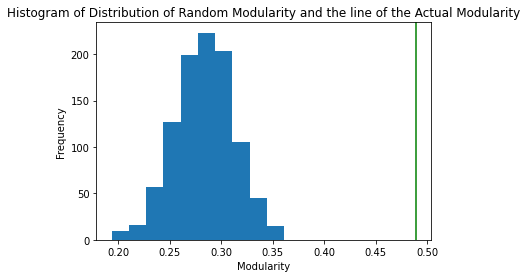

In [14]:
import matplotlib.pyplot as plt
club_split = nx.get_node_attributes(G_karate, "club")
modularity = compute_modularity(G_karate, club_split)
print(f"Actual modularity: {modularity:.3f}")

plt.hist(result, label='Random')
plt.axvline(modularity, color='green', label='Actual')
plt.xlabel('Modularity')
plt.ylabel('Frequency')
plt.title('Histogram of Distribution of Random Modularity and the line of the Actual Modularity')
plt.show()

10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?

We observe that the modularity of the "random" graphs center around 0.284, which is lower than the actual modularity. As modularity is a measure for the structure of a network, this indicates that the structure in the original graph is not entirely random.

The reason we want to preserve the degree of each node is, that the degree plays a significant role when determining the community structure. If we did not preserve the nodes degree the distribtuion of the degrees would change, and so would the community structure aswell.

11. Use the Python Louvain-algorithm implementation to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?


In [ ]:
import community

#Louvain algorithm
partition = community.best_partition(G_karate) # dictionary, keys are the nodes and values are communities for each node

# modularity of partition
modularity = community.modularity(partition, G_karate) 

print(f"Modularity: {modularity:.2f}")

A reason for the difference between Louvain and the modularity found before, could be because the partitioning of the graph is not clear cut, and that the communities can be partitioned in different ways. But they both indicate that there is some kind of structure, since their modularity is higher than that of the random graph.

12. Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix D with dimension (2 times A), where A is the number of communities found by Louvain. We set entry D(i,j) to be the number of nodes that community i has in common with group split j. The matrix D is what we call a confusion matrix. Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.


In [ ]:
#We start by loading the Karate club graph
G_karate = nx.karate_club_graph()

#First we get the club split partitioning from the node attributes
club_split = nx.get_node_attributes(G_karate, "club")

def convert_to_numb(club):
    if club == "Mr. Hi":
        return 0
    else:
        return 1

A = max(partition.values())+1 # 4 partitions
D = np.zeros((A,A))
for i in range(A):
    for j in range(A):
        #print(j)
        for node, club in club_split.items():
            if partition[node] == i and convert_to_numb(club) == j:
                D[i,j]+=1
print(D)

We see that the club split only has two clubs, whereas Louvain has 4 different clubs. In the case where Louvain and club split was the same, we would have D[0,0] = 17 and D[1,1] = 17, and not 11 and 11. It did find a good partioning (when looking at the modularity), but as both seen in confusion matrix and the modularity, it did not find the "correct" partioning. When looking at the trace we see that is better than random, but just by some amount.

**EXERCISE 3: COMMUNITY DETECTION ON THE NETWORK OF COMPUTATIONAL SOCIAL SCIENCE**

Use the Python Louvain-algorithm implementation to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0?


In [ ]:
from networkx.readwrite import json_graph
import networkx as nx
import json
import numpy as np
import pandas as pd
from netwulf import visualize

def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)
G = read_json_file("data_total.json")

In [ ]:
import community

#Louvain algorithm
partition = community.best_partition(G,random_state=42) # dictionary, keys are the nodes and values are communities for each node

# modularity of partition
modularity = community.modularity(partition, G) 

size = []
for community_ in set(partition.values()):
    temp = []
    for part in partition:
        if partition[part] == community_:
            temp.append(part)
    size.append(len(temp))

print("Number of communities:", len(set(partition.values())))
print("Community sizes:", sorted(size,reverse=True))
print(f"Modularity: {modularity:.2f}")


As seen the modularity is significantly larger than 0, indicated there is some community structure.

In [ ]:
import netwulf as nw
import colorsys
# Unable to visualise when using the graph with attributes, getting error "file not found"
G2 = read_json_file("data_total_no_attr.json") 


num_communities = len(set(partition.values()))
hue_start = 0.0
saturation = 0.8
value = 0.8

colors = []
for i in range(num_communities):
    hue = hue_start + (i / num_communities)
    r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
    color_hex = "#{:02x}{:02x}{:02x}".format(int(r * 255), int(g * 255), int(b * 255))
    colors.append(color_hex)

community_numb = list(partition.values())
for i, n in enumerate(G.nodes()):
    G2.nodes[n]['color'] = colors[community_numb[i]]

#visualize(G2)

network, config = visualize(G2)

Saving the assigned community to the author

In [ ]:
nx.set_node_attributes(G, partition, 'community')

# Test
G.nodes[1404354049]

## Part 3: TF-IDF

**Exercise 4: TF-IDF and the Computational Social Science communities**

- What does TF stand for

TF stands for term frequency. Term frequency is metric that tells us how many instances of a given word (term) there is in a document. The way we get the term frequency is by getting the set of words of a given document, and then we count how many times each word occurs and divide that by the total number of words. So if a word has a term frequency of 0.1, it means that of all the words in the document, this particular word occurs 10% of the time


- What does IDF stand for

IDF stand for inverse document frequency. IDF is a metric for how unique a word is to a given document. If the word occurs in every document we have, it is not really worth mentioning if we were asked to describe the given document


Let us take an example of why TD-IDF is used to tell which words hold the most information about a given document

If we were to only look at TF we would in most cases come to the conclusion that the word "the" is the most descriptive of a document, because it is by far the most used word in the english language. However because it is so popular it will most likely have an IDF of 0 in any corpus consisting of english documents, which means that the TF-IDF of "the" would in any english corpus yield 0


In [ ]:
import nltk # natural language processing toolkit

In [ ]:
# read data file
df_tokens = pd.read_parquet("paper_abstract_df_tokens.parquet") # contains the abstracts of the papers, and the tokens (words) in the abstracts
df_authors = pd.read_parquet("author_ids_df_week6.parquet") # contains author ids, which community they belong to, and the authors degree (number of edges (people the author has co-authored with))



Now, we want to find out which words are important for each community, so we're going to create several *large documents, one for each community*. Each document includes all the tokens of abstracts written by members of a given community.

- Consider a community c
- Find all the abstracts of papers written by a member of community c.
- Create a long array that stores all the abstract tokens
- Repeat for all the communities.

In [ ]:
# A function that takes a community as input and gives the paperids of the papers written by the authors in the community
def get_paperids(community):
    paperids = []
    for author in community["author_id"]:
        ids = df_tokens[df_tokens["authorIds"].apply(lambda x: author in x)][["paperId"]]
        if len(ids) > 0:
            paperids.append(ids.values[0][0])
    return list(set(paperids))


# Get the tokens of a list of paperIds
def get_tokens(paperids):
    tokens = []
    for paperid in paperids:
        temp = df_tokens[df_tokens["paperId"] == paperid]["tokens"].values
        if len(temp) > 0:
            # join the tokens into the same list
            tokens.extend(temp[0])
    return tokens


In [ ]:
# now we do this process for all communities

# groupby community
grouped = df_authors.groupby("community")

# for each community apply the two functions
communities = grouped.apply(lambda x: get_tokens(get_paperids(x)) if len(get_paperids(x)) > 0 else None)
# we now have a list of lists, where each list contains the tokens of the papers written by the authors in the community
# we drop the communities that have no papers
communities.dropna(inplace=True)
len(communities)


In [ ]:
# we start by implementing the more general solution, and then we can ask for the top 5 communities etc.
# we define a corpus as an index so we can vary the size of the corpus
corpus = communities

# We define a function that given a corpus (list of lists) with tokens outputs all the words in the corpus
def get_words(corpus):
    words = set()
    for tokens in corpus:
        words.update(tokens)
    return words

# we define a function that calculates the tf / idf and outputs

def tf_idf(corpus, df_authors, top_n:int=None):
    data = dict()
    if top_n:
        top_n_index = df_authors.groupby("community").count().sort_values("author_id", ascending=False).head(top_n).index
        corpus = communities[top_n_index]
        data["top_n_index"] = top_n_index
    else:
        corpus = communities
    # calculate the term frequency (TF) of the corpus
    tf_dist = [nltk.FreqDist(tokens) for tokens in corpus]

    # Get all the words in the corpus
    all_words = get_words(corpus)

    # calculate tf-idf for the corpus
    # only calculate tf-idf for the words in the TF
    tf_idf = [{word: tf[word] * np.log(len(corpus)/sum([word in tokens for tokens in corpus])) for word in tf.keys()} for tf in tf_dist]
    data["tf"] = tf_dist
    data["tf_idf"] = tf_idf

    return data

In [ ]:
# compute the tf-idf for the top 5 communities
tf_idf_top_5 = tf_idf(corpus, df_authors, top_n=5)

- Describe similarities and differences between the communities.
- Why aren't the TFs not necessarily a good description of the communities?
- Next, we calculate IDF for every word.
- What base logarithm did you use? Is that important?

In [ ]:
# lets look at the TFs for the top 5 communities
tf_idf_top_5["tf"]


We see that the term frequencies are quite similar for the top 5 communitiews. 4 out of 5 of them have social as their mosed used word, and 3 of them have data as their second.


When we want to describe something the most important things to mention are what makes them special. so if we just used term frequency to describe a community, we would say that the word "social" describes them the best, however 4 of them have this as the most used word, so if we used this word to describe them, how would we be able to tell them apart. This is where tf-idf comes in

For the IDF we use just **np.log** which is just the natural logarithm (base e). It does not matter which logarithm we use as all logarithms are asymptotically the same, and we can go from one base logarithm to another by the following formula:

$$
\log _b a=\frac{\log _d a}{\log _d b}
$$

So if wanted all the values of


In [ ]:
# change of base from ln to log10
np.log(10)/np.log(np.e)

So if we wanted to change the base of the logarithm, we would just multiply all the values in the tf-idf by the given constant. And as we scale all the values by the same factor, it really doesnt matter which base we use.


We have already calculated the TF-IDF for our corpus, we can access it in the directionary we returned:

In [ ]:
tf_idf_top_5["tf_idf"]

# however these are not sorted, so we need to sort them
# we define a function that takes a list of dictionaries and sorts them by the values
def sort_dict_list(dict_list):
    return [dict(sorted(d.items(), key=lambda item: item[1], reverse=True)) for d in dict_list]

# we now sort the tf-idf
tf_idf_top_5["tf_idf"] = sort_dict_list(tf_idf_top_5["tf_idf"])

In [ ]:
# let us look at the top 10 words for each community
for i, val in enumerate(tf_idf_top_5["tf_idf"]):
    print(f"Community {i+1}")
    print(list(val.items())[:10])

In [ ]:
# list the top 3 authors by degree
df_authors.sort_values("degree", ascending=False).head(3)

In [ ]:
# to see why tf-idf is useful, let us look at the word "welfare" in the 3rd entry which has a really high tf-idf
# let us first see how many times the word "welfare" appears in the 3rd community
tf_idf_top_5["tf"][2]["welfare"]

In [ ]:
# It appears quite a lot in the 3rd community, Let us now see if it appears in the other communities
[tf["welfare"] for tf in tf_idf_top_5["tf"]]

# This gives us a good explaination of why the word "welfare" has a high tf-idf in the 3rd community. It appears a lot in the 3rd community, but not at all in the other communities. So it will have a very high tf-idf in the 3rd community.

In [ ]:
# TF-IDF for all communities
tf_idf_top_9 = tf_idf(corpus, df_authors, top_n=9)

**Exercise 5: The Wordcloud**

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# TF-IDF for top 9 communities
tf_idf_top_9 = tf_idf(corpus, df_authors, top_n=9)

In [ ]:
# for each community create a wordcloud
for i in range(len(tf_idf_top_9["tf_idf"])):
    community_tf = tf_idf_top_9["tf"][i]
    community_tf_idf = tf_idf_top_9["tf_idf"][i]
    
    if len(community_tf) < 1:
        continue

    # get the top 3 authors by degree in the community
    # top_3_authors = df_authors[df_authors["community"] == i].sort_values("degree", ascending=False).head(3)["author_id"].values
    top_3_authors = df_authors[df_authors["community"] == i].sort_values("degree", ascending=False).head(3)["name"].values
    print(f"Community {i} - Top 3 authors: {top_3_authors}")
    
    wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate_from_frequencies(community_tf_idf)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Community {i}")
    plt.show()
